In [1]:
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import pandas as pd

In [2]:
# Import the training set
dataset_train = pd.read_csv('Stock_2464_2018_2019.csv')  # 讀取2018~2019年10月訓練集共446筆

In [3]:
training_set = dataset_train.iloc[:, 3:4].values  # 取「OPEN」欄位值

In [4]:
#標準化
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [5]:
training_set_scaled.shape

(446, 1)

In [6]:
X_train = []   #預測點的前 60 天的資料
y_train = []   #預測點
for i in range(60, 446):  # 446 是訓練集總數
    X_train.append(training_set_scaled[i-60:i, 0]) #取1~60天資料(0~59)作為輸入資訊
    y_train.append(training_set_scaled[i, 0])      #取第61天資料(60)作為輸出結果
X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN

In [7]:
print(X_train.shape)
print(y_train.shape)

(386, 60)
(386,)


In [8]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape #[stock prices, timesteps, indicators]

(386, 60, 1)

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,SimpleRNN,TimeDistributed,Flatten
from keras.layers import Dropout

Using TensorFlow backend.


In [10]:
model=Sequential()
model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1), activation='sigmoid'))
model.add(Dropout(0.2))
model.add(LSTM(units =128, return_sequences = True, activation='sigmoid'))
#model.add(Dropout(0.2))
model.add(LSTM(units = 64, return_sequences = True, activation='sigmoid'))
#model.add(Dropout(0.2))
model.add(LSTM(units = 32, activation='sigmoid'))
#model.add(Dropout(0.2))
model.add(Dense(units = 1))

In [11]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error') #使用adam優化器,以及MSE損失函數
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 128)           66560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 128)           131584    
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 64)            49408     
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 260,001
Trainable params: 260,001
Non-trainable params: 0
_________________________________________________________________
None

In [12]:
train_history=model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
386/386 [==============================] - 4s 11ms/step - loss: 0.0307
Epoch 2/100
386/386 [==============================] - 2s 6ms/step - loss: 0.0251
Epoch 3/100
386/386 [==============================] - 2s 6ms/step - loss: 0.0249
Epoch 4/100
386/386 [==============================] - 3s 7ms/step - loss: 0.0246
Epoch 5/100
386/386 [==============================] - 3s 6ms/step - loss: 0.0249
Epoch 6/100
386/386 [==============================] - 3s 7ms/step - loss: 0.0247
Epoch 7/100
386/386 [==============================] - 3s 7ms/step - loss: 0.0258
Epoch 8/100
386/386 [==============================] - 3s 7ms/step - loss: 0.0245
Epoch 9/100
386/386 [==============================] - 3s 7ms/step - loss: 0.0247
Epoch 10/100
386/386 [==============================] - 3s 7ms/step - loss: 0.0252
Epoch 11/100
386/386 [==============================] - 3s 7ms/step - loss: 0.0261
Epoch 12/100
386/386 [==============================] - 3s 7ms/step - loss: 0.0246
Epoch 13/100

386/386 [==============================] - 3s 8ms/step - loss: 0.0028
Epoch 100/100
386/386 [==============================] - 3s 7ms/step - loss: 0.0028


In [13]:
dataset_test = pd.read_csv('STOCK_2464_2019_12.csv')#當前11月及12月前8資料共29筆

In [14]:
dataset_total = pd.concat((dataset_train['OPEN'], dataset_test['OPEN']), axis = 0)#將訓練資料+測試資料集結共475筆
real_stock_price=dataset_total[60:]#取得總資料集第61天後資料作為真實,共415筆
real_stock_price=np.array(real_stock_price)
real_stock_price.shape

(415,)

In [15]:
inputs = dataset_total[:].values #取所有資料作為input資訊
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs) # Feature Scaling
outputs=[]
outputs = np.array(outputs)
inputs.shape

(475, 1)

In [16]:
#下排迴圈作為控制取用範圍,將1~60天資料作為X_test去預測第61天資料,以迴圈逐步選取範圍
#將總資料1~60筆投入預測知道61天,2~61筆預測62天,逐步推算至475天,將預測資料與真實資料(61天後)做比對
#已知倒數29天為測試資料,會以59天訓練資料+1天測試資料 -> 58天訓練資料+2天測試資料逐步推算預測數值

In [17]:
for i in range (60,475):
    X_test = []
    X_test.append(inputs[i-60:i])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    #print(inputs.shape)
    predicted_stock_price = model.predict(X_test)
    outputs=np.append(outputs,predicted_stock_price)
    #predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    #print(predicted_stock_price)

In [18]:
#還原已標準化數值
outputs_real_value = sc.inverse_transform(outputs.reshape(-1,1))
#inputs_real_value = inputs_real_value[len(inputs_real_value):]
outputs_real_value.shape

(415, 1)

In [19]:
print(real_stock_price.shape)
print(outputs_real_value.shape)

(415,)
(415, 1)


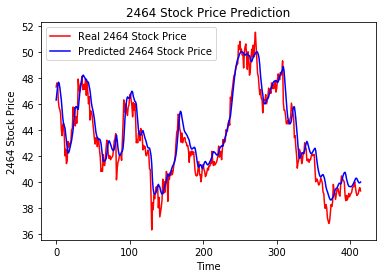

In [20]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real 2464 Stock Price')  # 紅線表示真實股價
plt.plot(outputs_real_value, color = 'blue', label = 'Predicted 2464 Stock Price')  # 藍線表示預測股價
plt.title('2464 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('2464 Stock Price')
plt.legend()
plt.show()

In [22]:
#conclusion
#not sure if every stock is suitable, it needs to try more times and other stocks
#our predict value are smoother than real value
#and last 29 days are closer with real value too."""